In [1]:
!unzip data.zip

Archive:  data.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  


In [9]:
# ## 1. Setup and Imports
# 필요한 라이브러리를 모두 불러옵니다.
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import imageio # GIF 생성을 위해 추가
from PIL import Image # 이미지 리사이징을 위해 추가
import time
import os

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


In [ ]:
# ## 2. Hyperparameters and Constants
# 모델과 학습에 필요한 하이퍼파라미터를 한 곳에서 관리합니다.
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 50
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 100 # 10x10 격자 이미지 생성
NUM_CLASSES = 10
IMAGE_SHAPE = (28, 28, 1)

# Fashion MNIST 클래스 레이블
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 생성된 이미지와 GIF를 저장할 디렉토리 생성
if not os.path.exists('cgan_images'):
    os.makedirs('cgan_images')

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)


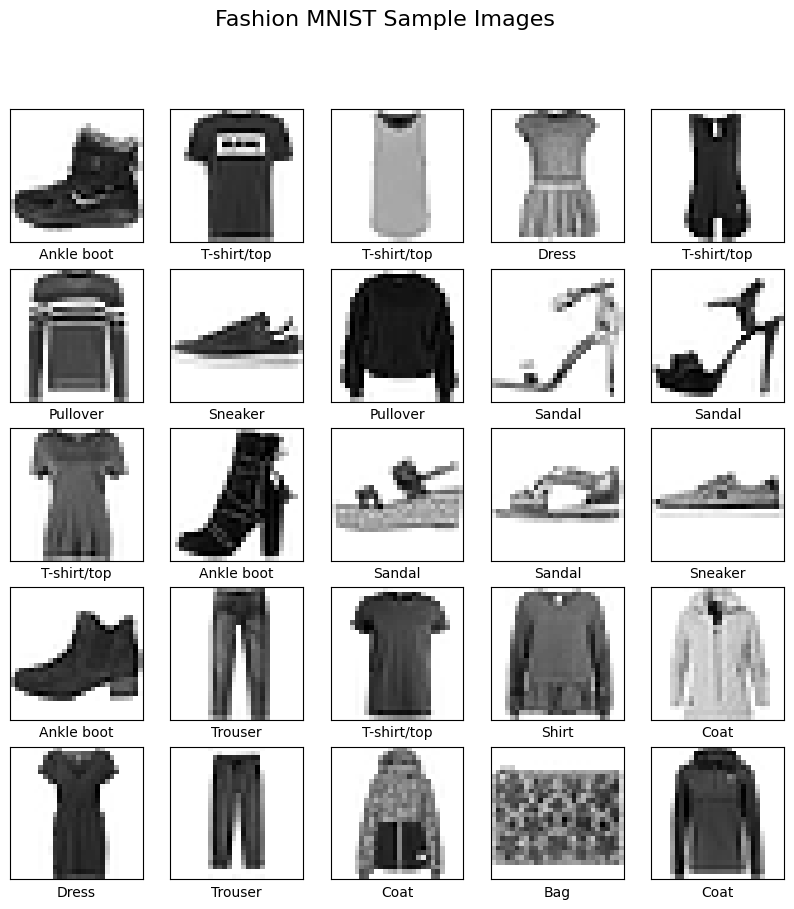

In [ ]:
# ## 3. Data Loading & Exploratory Data Analysis (EDA)
# Fashion MNIST 데이터셋을 로드하고, 데이터의 형태와 샘플 이미지를 확인합니다.

# 데이터셋 로드
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

print(f"\nTraining images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")

# 샘플 이미지 시각화
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.suptitle("Fashion MNIST Sample Images", fontsize=16)
plt.show()

In [5]:
# ## 4. Data Preprocessing
# 이미지를 GAN 학습에 적합한 형태로 전처리하고, tf.data.Dataset으로 만듭니다.

# 이미지 reshape 및 -1 ~ 1 사이로 정규화
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

# tf.data.Dataset으로 변환하여 효율적인 학습 파이프라인 구성
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [10]:
# ## 5. CGAN Model Definition
# Conditional GAN의 생성자(Generator)와 판별자(Discriminator)를 정의합니다.

# ### 5.1. Generator
# 노이즈 벡터와 클래스 레이블을 입력받아 이미지를 생성합니다.
def make_generator_model():
    # Input 1: Noise vector
    noise_input = layers.Input(shape=(NOISE_DIM,))

    # Input 2: Class label (임베딩을 통해 노이즈와 결합)
    label_input = layers.Input(shape=(1,))
    label_embedding = layers.Embedding(NUM_CLASSES, 50)(label_input)
    label_embedding = layers.Dense(7*7)(label_embedding)
    label_embedding = layers.Reshape((7, 7, 1))(label_embedding)

    # 초기 노이즈를 7x7x256 이미지 형태로 변환
    noise_dense = layers.Dense(7*7*256, use_bias=False)(noise_input)
    noise_dense = layers.BatchNormalization()(noise_dense)
    noise_dense = layers.LeakyReLU()(noise_dense)
    noise_reshaped = layers.Reshape((7, 7, 256))(noise_dense)

    # 노이즈와 레이블 정보를 결합
    concat = layers.Concatenate()([noise_reshaped, label_embedding])

    # Conv2DTranspose를 통해 점진적으로 이미지 크기를 키움 (7x7 -> 14x14 -> 28x28)
    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(concat)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # 최종 출력 레이어: -1 ~ 1 사이의 값을 가지는 28x28x1 이미지 생성
    output_image = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    return Model(inputs=[noise_input, label_input], outputs=output_image)

In [11]:
# ### 5.2. Discriminator
# 이미지와 클래스 레이블을 입력받아 해당 이미지가 '진짜'인지 '가짜'인지 판별합니다.
def make_discriminator_model():
    # Input 1: Image
    image_input = layers.Input(shape=IMAGE_SHAPE)

    # Input 2: Class label
    label_input = layers.Input(shape=(1,))
    label_embedding = layers.Embedding(NUM_CLASSES, 50)(label_input)
    label_embedding = layers.Dense(IMAGE_SHAPE[0] * IMAGE_SHAPE[1])(label_embedding)
    label_embedding = layers.Reshape((IMAGE_SHAPE[0], IMAGE_SHAPE[1], 1))(label_embedding)

    # 이미지와 레이블 정보를 결합
    concat = layers.Concatenate()([image_input, label_embedding])

    # Conv2D를 통해 특징 추출 및 다운샘플링
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(concat)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)

    # 최종 출력: 이미지가 진짜일 확률 (0~1)
    output_prob = layers.Dense(1)(x)

    return Model(inputs=[image_input, label_input], outputs=output_prob)

In [12]:
# ## 6. Training Setup
# 손실 함수, 옵티마이저, 그리고 모델 인스턴스를 생성합니다.

# 모델 인스턴스 생성
generator = make_generator_model()
discriminator = make_discriminator_model()

# 손실 함수 (Binary Crossentropy 사용)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator Loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generator Loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# 옵티마이저 (Adam 사용)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 테스트용 시드 노이즈 및 레이블 생성 (학습 과정 시각화에 사용)
seed_noise = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])
seed_labels = np.arange(NUM_CLASSES).repeat(NUM_EXAMPLES_TO_GENERATE // NUM_CLASSES)
seed_labels = tf.constant(seed_labels, dtype=tf.int32)


In [13]:
# ## 7. Custom Training Loop
# tf.GradientTape를 사용하여 GAN의 학습 과정을 직접 구현합니다.

# 매 에포크마다 이미지를 생성하고 저장하는 헬퍼 함수
def generate_and_save_images(model, epoch, test_input, test_labels):
    predictions = model([test_input, test_labels], training=False)
    fig = plt.figure(figsize=(10, 10))
    for i in range(predictions.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Image generation at epoch {epoch+1}', fontsize=16)
    plt.savefig(f'cgan_images/image_at_epoch_{epoch+1:04d}.png')
    plt.close(fig) # show() 대신 close()를 사용해 바로 출력하지 않음

In [17]:
# 1 스텝 학습 함수 (tf.function으로 컴파일하여 성능 향상)
@tf.function
def train_step(images, labels):
    # BATCH_SIZE 대신 현재 labels 배치의 실제 크기를 사용하도록 수정
    noise = tf.random.normal([tf.shape(labels)[0], NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)

        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [18]:
# 전체 학습을 관리하는 함수
def train(dataset, epochs):
    gen_loss_history = []
    disc_loss_history = []

    for epoch in range(epochs):
        start = time.time()

        epoch_gen_loss = []
        epoch_disc_loss = []

        for image_batch, label_batch in dataset:
            g_loss, d_loss = train_step(image_batch, label_batch)
            epoch_gen_loss.append(g_loss)
            epoch_disc_loss.append(d_loss)

        # 에포크별 평균 손실 기록
        gen_loss_history.append(np.mean(epoch_gen_loss))
        disc_loss_history.append(np.mean(epoch_disc_loss))

        # 시각화를 위해 이미지 생성 및 저장
        generate_and_save_images(generator, epoch, seed_noise, seed_labels)

        print(f'Time for epoch {epoch + 1} is {time.time()-start:.2f} sec. Gen Loss: {gen_loss_history[-1]:.4f}, Disc Loss: {disc_loss_history[-1]:.4f}')

    return gen_loss_history, disc_loss_history

In [ ]:
# 모델 학습 실행
print("\n--- Starting Training ---")
gen_loss, disc_loss = train(train_dataset, EPOCHS)
print("--- Training Finished ---")


--- Starting Training ---
Time for epoch 1 is 18.39 sec. Gen Loss: 0.8542, Disc Loss: 1.2797
Time for epoch 2 is 14.11 sec. Gen Loss: 0.8745, Disc Loss: 1.2829
Time for epoch 3 is 14.61 sec. Gen Loss: 0.7682, Disc Loss: 1.3456
Time for epoch 4 is 15.12 sec. Gen Loss: 0.8933, Disc Loss: 1.2154
Time for epoch 5 is 14.56 sec. Gen Loss: 1.2894, Disc Loss: 1.0164
Time for epoch 6 is 14.53 sec. Gen Loss: 1.2764, Disc Loss: 1.0205
Time for epoch 7 is 14.07 sec. Gen Loss: 1.4108, Disc Loss: 0.9551
Time for epoch 8 is 14.71 sec. Gen Loss: 1.6291, Disc Loss: 0.8449
Time for epoch 9 is 14.22 sec. Gen Loss: 1.5589, Disc Loss: 0.8854
Time for epoch 10 is 14.65 sec. Gen Loss: 1.5118, Disc Loss: 0.9599
Time for epoch 11 is 15.06 sec. Gen Loss: 1.2907, Disc Loss: 1.0661
Time for epoch 12 is 14.11 sec. Gen Loss: 1.2474, Disc Loss: 1.0901
Time for epoch 13 is 14.05 sec. Gen Loss: 1.2036, Disc Loss: 1.0469
Time for epoch 14 is 14.07 sec. Gen Loss: 1.3224, Disc Loss: 0.9706
Time for epoch 15 is 15.45 sec

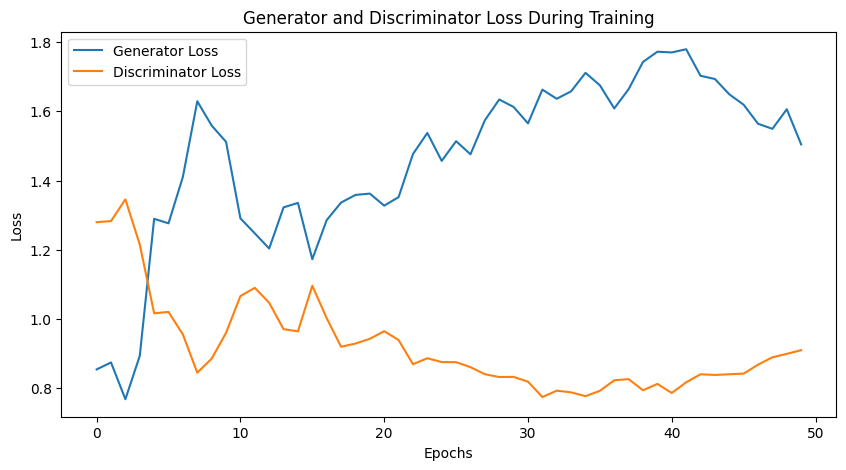

In [20]:
# ## 8. Results Visualization
# 학습 결과를 시각화합니다.

# ### 8.1. Generator and Discriminator Loss Curves
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_loss, label="Generator Loss")
plt.plot(disc_loss, label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
# ### 8.2. GIF of Training Progress
print("\nCreating GIF animation of the training process...")
anim_file = 'cgan_fashion_mnist.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = sorted([f for f in os.listdir('cgan_images') if f.endswith('.png')])
    for filename in filenames:
        image = imageio.imread(os.path.join('cgan_images', filename))
        writer.append_data(image)
print(f"GIF saved as {anim_file}")


Creating GIF animation of the training process...


/tmp/ipython-input-1390546642.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join('cgan_images', filename))


GIF saved as cgan_fashion_mnist.gif



Displaying final generated images:


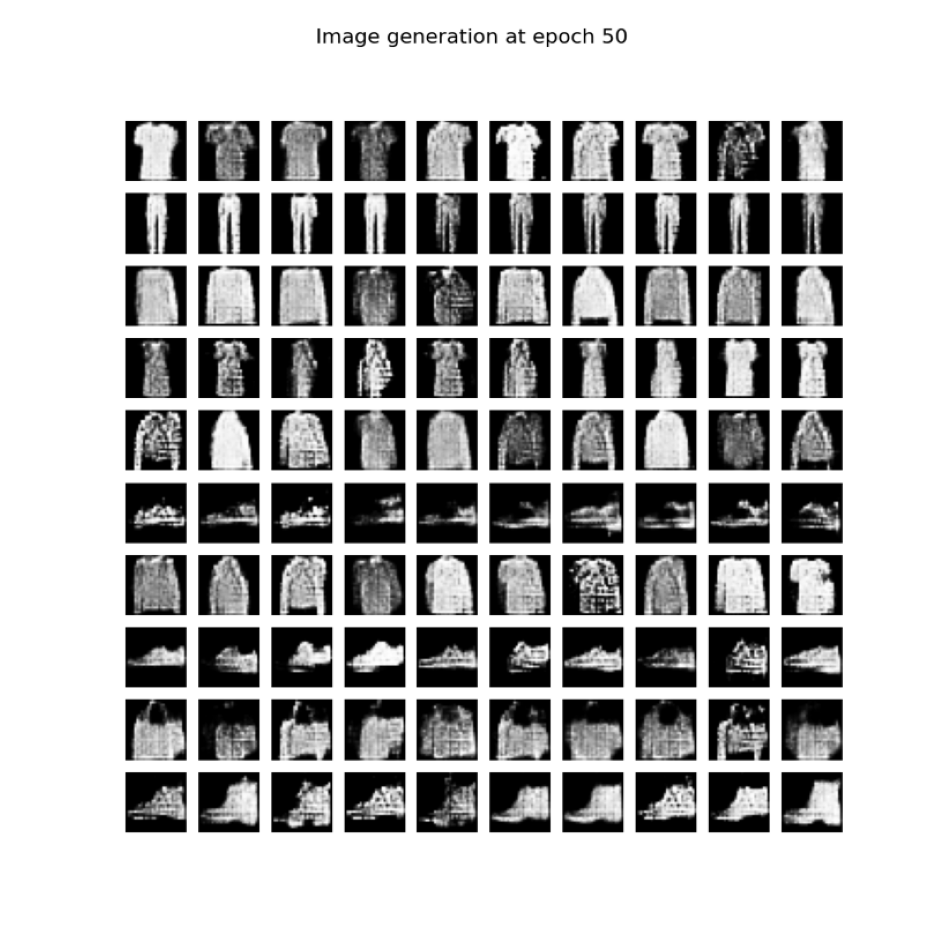

In [22]:
# 마지막으로 생성된 이미지 그리드를 보여줍니다.
final_image_path = f'cgan_images/image_at_epoch_{EPOCHS:04d}.png'
if os.path.exists(final_image_path):
    print("\nDisplaying final generated images:")
    display_img = Image.open(final_image_path)
    display_img.thumbnail((800, 800))
    plt.figure(figsize=(12, 12))
    plt.imshow(display_img)
    plt.axis('off')
    plt.show()